Packages 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import folium
import plotly.express as px
import nbformat
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

Data import

In [3]:
df = pd.read_excel("./data/Pittsburgh_AMS_Mobile_2016_2017.xlsx")

In [4]:
# Drop rows with missing NO2 since that is our target variable
df_NO2 = df.dropna(subset=['NO2'])

Preliminary data cleaning

In [5]:
# Splite the datetime into date and time, and extract year from date, count the number of records for each year
df_NO2["date"] = df_NO2["datetime"].dt.date
df_NO2["time"] = df_NO2["datetime"].dt.time
df_NO2["year"] = df_NO2["datetime"].dt.year
df_NO2["day"] = df_NO2["datetime"].dt.day

/var/folders/jb/d50lm02n7cz_c9129ll301m40000gn/T/ipykernel_10435/1221647113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NO2["date"] = df_NO2["datetime"].dt.date
/var/folders/jb/d50lm02n7cz_c9129ll301m40000gn/T/ipykernel_10435/1221647113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NO2["time"] = df_NO2["datetime"].dt.time
/var/folders/jb/d50lm02n7cz_c9129ll301m40000gn/T/ipykernel_10435/1221647113.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [6]:
# check which days there are samples
df_NO2.groupby(["year", "month", "day"]).size()

year  month  day
2016  8      8        61
             9       111
             11      287
             12      286
             15      313
             17       86
      9      13      147
             15      298
             20      303
             22      133
             23       85
             26      288
      11     16      615
             18      740
             21      687
             22      682
2017  1      25     1070
             26      320
             27      324
             30      119
             31      831
      2      1       414
             2       897
             3       488
             6       270
             7       631
             8       171
             13      526
             14      662
             15      235
             16      697
             17      600
dtype: int64

Note: these dates are all week days, no sampling occured on weekends

# Create validation/future prediction set

Check which times of day are sampled during the last three days

In [35]:
print(min(df_NO2[(df_NO2["day"] > 14) & (df_NO2["month"] == 2)]["time"]))
print(max(df_NO2[(df_NO2["day"] > 14) & (df_NO2["month"] == 2)]["time"]))

#which times of day were sampled
print(df_NO2[(df_NO2["day"] > 14) & (df_NO2["month"] == 2)].groupby("hour").size())

05:06:59
23:21:43
hour
5     150
6      85
10     54
11    169
12    170
13    171
14     36
19    129
20    171
21    168
22    170
23     59
dtype: int64


Check which times of day are sampled during all the other weeks

In [36]:
print(min(df_NO2[(df_NO2["day"] <= 14) | (df_NO2["month"] != 2)]["time"]))
print(max(df_NO2[(df_NO2["day"] <= 14) | (df_NO2["month"] != 2)]["time"]))

#which hours of day were sampled
print(df_NO2[(df_NO2["day"] <= 14) | (df_NO2["month"] != 2)].groupby("hour").size())

03:07:59
22:34:01
hour
3      123
4      190
5      271
6      372
7      407
8      479
9      454
10     489
11     499
12     608
13    1270
14    1236
15     877
16    1028
17     727
18     858
19     980
20     605
21     279
22      93
dtype: int64


Check which locations are sampled during the last week

In [56]:
# create dataset with just last three days of observations, remove those that were later than 22 hr
df_lastwk = df_NO2[(df_NO2["day"] > 14) & (df_NO2["month"] == 2) & (df_NO2["hour"] < 23)]
df_lastwk.head(n = 6)

,OBJECTID,datetime,run_index,Longitude,Latitude,Elevation,hour,CO2,CO,NO,...,BCLocal,weight,site,period,season,type,date,time,year,day
14482,14483,2017-02-15 05:06:59,165150,-79.942601,40.442071,297.225000,5,474.204300,0.069805,0.247768,...,-0.017092,1,0,1,3,1,2017-02-15,05:06:59,2017,15
14483,14484,2017-02-15 05:07:20,165151,-79.942407,40.441984,297.504546,5,474.737900,0.073114,0.246886,...,0.715207,1,0,1,3,1,2017-02-15,05:07:20,2017,15
14484,14485,2017-02-15 05:07:41,165152,-79.941691,40.441671,291.659091,5,476.177000,0.076582,0.245027,...,0.097918,1,0,1,3,1,2017-02-15,05:07:41,2017,15
14485,14486,2017-02-15 05:08:02,165153,-79.942127,40.440642,283.004546,5,473.499286,0.076400,0.271050,...,0.147311,1,0,1,3,3,2017-02-15,05:08:02,2017,15
14486,14487,2017-02-15 05:08:23,165154,-79.943268,40.439866,272.072727,5,466.450227,0.074564,0.335505,...,-0.036247,1,0,1,3,3,2017-02-15,05:08:23,2017,15
14487,14488,2017-02-15 05:08:44,165155,-79.945521,40.438875,257.922727,5,472.234414,0.073536,0.351541,...,-0.494668,1,0,1,3,3,2017-02-15,05:08:44,2017,15


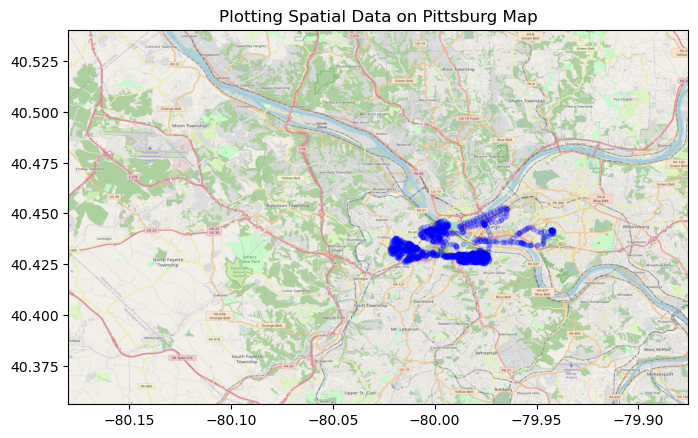

In [57]:
mapbox_api_token = 'pk.eyJ1IjoibWFyY2lhYWFtYSIsImEiOiJjbG9vbW05ZDIwMWhiMmtvZG1ldG55cnJ5In0.8vFy9eh9od6Su_RMcCs4IQ'

color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df_lastwk, 
                        lat="Latitude", 
                        lon="Longitude", 
                        color_continuous_scale=color_scale,
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

BBox = (df_NO2.Longitude.min(), df_NO2.Longitude.max(),      
         df_NO2.Latitude.min(), df_NO2.Latitude.max())

pittsburg_map = plt.imread('map.png')


fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df_lastwk.Longitude, df_lastwk.Latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on Pittsburg Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(pittsburg_map, zorder=0, extent = BBox, aspect= 'equal')

The last three days (the 15th, 16th, 17th) will form our validation/future prediction dataset

In [61]:
df_lastwk.shape

(1473, 51)

Save validation/future prediction dataset

In [62]:
df_lastwk.to_excel('validation.xlsx', index=False)

# Create training/testing splits

Split data into test and training datasets using k-fold CV (k = 10)

In [63]:
from sklearn.model_selection import KFold

In [73]:
df_testtrain = df_NO2[(df_NO2["day"] <= 14) | (df_NO2["month"] != 2)]
df_testtrain.shape

(11845, 51)

In [77]:

kf = KFold(n_splits=10)
for train, test in kf.split(df_testtrain):
    print(len(train), len(test))
    print("%s %s" % (train, test))

10660 1185
[ 1185  1186  1187 ... 11842 11843 11844] [   0    1    2 ... 1182 1183 1184]
10660 1185
[    0     1     2 ... 11842 11843 11844] [1185 1186 1187 ... 2367 2368 2369]
10660 1185
[    0     1     2 ... 11842 11843 11844] [2370 2371 2372 ... 3552 3553 3554]
10660 1185
[    0     1     2 ... 11842 11843 11844] [3555 3556 3557 ... 4737 4738 4739]
10660 1185
[    0     1     2 ... 11842 11843 11844] [4740 4741 4742 ... 5922 5923 5924]
10661 1184
[    0     1     2 ... 11842 11843 11844] [5925 5926 5927 ... 7106 7107 7108]
10661 1184
[    0     1     2 ... 11842 11843 11844] [7109 7110 7111 ... 8290 8291 8292]
10661 1184
[    0     1     2 ... 11842 11843 11844] [8293 8294 8295 ... 9474 9475 9476]
10661 1184
[    0     1     2 ... 11842 11843 11844] [ 9477  9478  9479 ... 10658 10659 10660]
10661 1184
[    0     1     2 ... 10658 10659 10660] [10661 10662 10663 ... 11842 11843 11844]
